#  ** TensorFlow를 이용한 LSTM 교통 예측 **


# **Bidirectional LSTM :** 

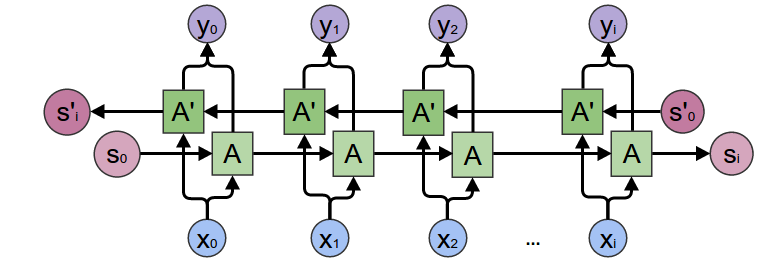


# **Goal:**
* *** 대전시 교통 데이터의 미래를 예측하자 ***

# **Here are the steps:**
* <a href='#Data'>Data</a>
* <a href='#Feature Engineering'>Feature Engineering</a>
* <a href='#Exploratory Data Analysis'>Exploratory Data Analysis</a>
* <a href='#Preprocessing'>Preprocessing</a>
* <a href='#Model Building'>Model Building</a>
* <a href='#Demand Predictions'>Demand Predictions</a>
* <a href='#Evaluation'>Evaluation</a>

# **GPU**

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import pandas as pd
df = pd.read_csv("./daejeon_vds16.csv")

In [4]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


<a id='Feature Engineering'></a>
# **Feature Engineering**

In [5]:
import numpy as np

In [6]:
df.shape

(8064, 7)

In [7]:
df.columns

Index(['Date', 'ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'Occ.Rate'], dtype='object')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8064 entries, 0 to 8063
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      8064 non-null   object 
 1   ToVol     8064 non-null   int64  
 2   SmVol     8064 non-null   int64  
 3   MeVol     8064 non-null   int64  
 4   LaVol     8064 non-null   int64  
 5   Speed     8064 non-null   float64
 6   Occ.Rate  8064 non-null   float64
dtypes: float64(2), int64(4), object(1)
memory usage: 441.1+ KB


In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
sns.set(context="notebook", style="darkgrid", palette="deep", font="sans-serif", font_scale=1, color_codes=True)

In [11]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [12]:
df["Date"] = pd.to_datetime(df["Date"])

In [13]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 00:00:00,43,34,9,0,50.3,1.90
1,2017-04-02 00:05:00,45,32,13,0,58.9,1.84
2,2017-04-02 00:10:00,46,34,12,0,50.6,1.87
3,2017-04-02 00:15:00,45,36,9,0,50.9,1.72
4,2017-04-02 00:20:00,27,13,13,1,62.2,1.12


In [15]:
df = df.set_index("Date")

In [16]:
df["hour"] = df.index.hour
df["day_of_month"] = df.index.day
df["day_of_week"]  = df.index.dayofweek
df["month"] = df.index.month

## 컬럼 이름 변경 Occ.Rate를 Occupancy

In [48]:
df.rename(columns={'Occ.Rate':'Occupancy'}, inplace=True)

In [49]:
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occupancy,hour,day_of_month,day_of_week,month
Date,,,,,,,,,,
2017-04-02 00:00:00,43,34,9,0,50.3,1.90,0,2,6,4
2017-04-02 00:05:00,45,32,13,0,58.9,1.84,0,2,6,4
2017-04-02 00:10:00,46,34,12,0,50.6,1.87,0,2,6,4
2017-04-02 00:15:00,45,36,9,0,50.9,1.72,0,2,6,4
2017-04-02 00:20:00,27,13,13,1,62.2,1.12,0,2,6,4


In [18]:
df.columns

Index(['ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'Occ.Rate', 'hour',
       'day_of_month', 'day_of_week', 'month'],
      dtype='object')

In [19]:
df.shape

(8064, 10)

In [20]:
corr_matrix = df.corr().abs()

In [21]:
high_corr_var=np.where(corr_matrix>0.8)

In [22]:
high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

In [23]:
print(high_corr_var)

[('ToVol', 'SmVol'), ('ToVol', 'MeVol'), ('SmVol', 'MeVol')]


In [24]:
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,hour,day_of_month,day_of_week,month
Date,,,,,,,,,,
2017-04-02 00:00:00,43,34,9,0,50.3,1.90,0,2,6,4
2017-04-02 00:05:00,45,32,13,0,58.9,1.84,0,2,6,4
2017-04-02 00:10:00,46,34,12,0,50.6,1.87,0,2,6,4
2017-04-02 00:15:00,45,36,9,0,50.9,1.72,0,2,6,4
2017-04-02 00:20:00,27,13,13,1,62.2,1.12,0,2,6,4


<a id='Exploratory Data Analysis'></a>
# **Exploratory Data Analysis**

<AxesSubplot:>

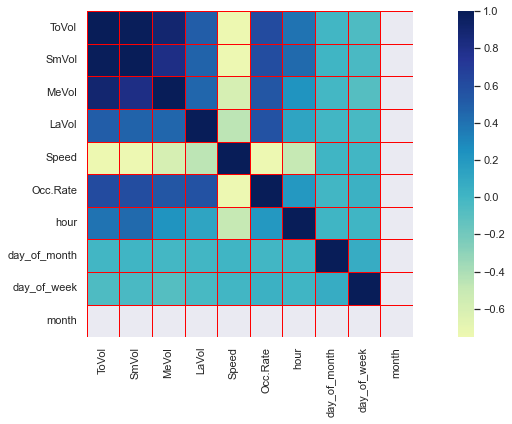

In [25]:
plt.figure(figsize=(16,6))
sns.heatmap(df.corr(),cmap="YlGnBu",square=True,linewidths=.5,center=0,linecolor="red")

From the above heatmap we can say that **t1** and **t2** are Highly Correlated with each other.

<AxesSubplot:ylabel='Date'>

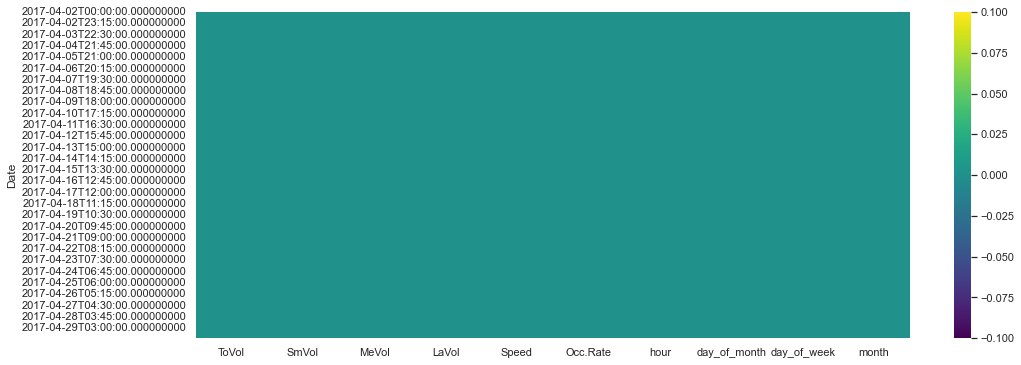

In [26]:
plt.figure(figsize=(16,6))
df.isnull().sum()
sns.heatmap(df.isnull(),cmap="viridis")

**이 클린 히트맵은 데이터에 Null 값이 하나라도 없음을 나타냅니다**

(array([17257., 17261., 17265., 17269., 17273., 17277., 17281., 17285.,
        17287.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

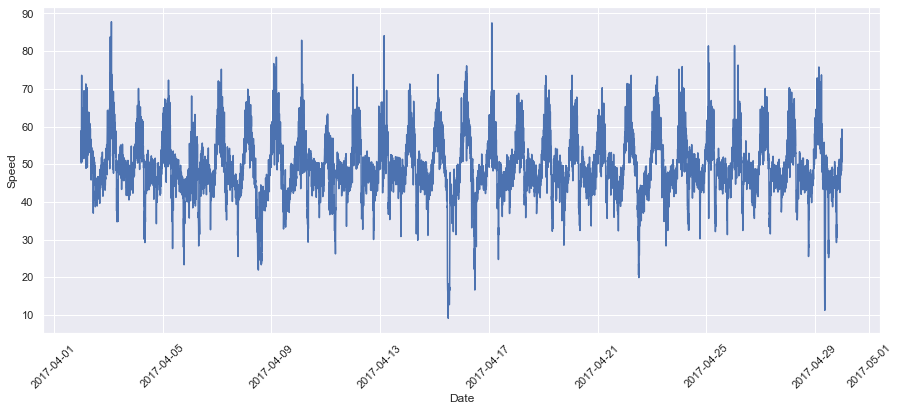

In [27]:
plt.figure(figsize=(15,6))
sns.lineplot(data=df, x=df.index, y=df.Speed)
plt.xticks(rotation=45)

In [29]:
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate,hour,day_of_month,day_of_week,month
Date,,,,,,,,,,
2017-04-02 00:00:00,43,34,9,0,50.3,1.90,0,2,6,4
2017-04-02 00:05:00,45,32,13,0,58.9,1.84,0,2,6,4
2017-04-02 00:10:00,46,34,12,0,50.6,1.87,0,2,6,4
2017-04-02 00:15:00,45,36,9,0,50.9,1.72,0,2,6,4
2017-04-02 00:20:00,27,13,13,1,62.2,1.12,0,2,6,4


(array([17257., 17261., 17265., 17269., 17273., 17277., 17281., 17285.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

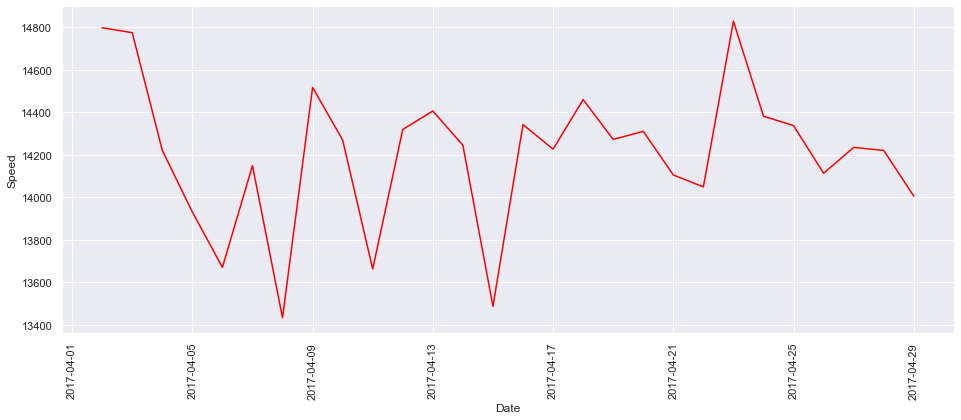

In [39]:
df_by_month = df.resample("D").sum()

plt.figure(figsize=(16,6))
sns.lineplot(data=df_by_month, x=df_by_month.index,y =df_by_month.Speed, color="red")
plt.xticks(rotation=90)

(array([17257., 17261., 17265., 17269., 17273., 17277., 17281., 17285.,
        17287.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

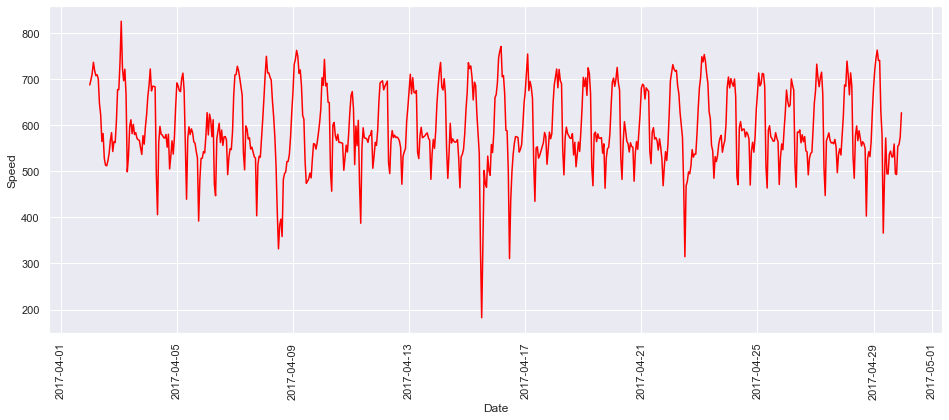

In [38]:
df_by_month = df.resample("H").sum()

plt.figure(figsize=(16,6))
sns.lineplot(data=df_by_month, x=df_by_month.index,y =df_by_month.Speed, color="red")
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='Speed'>

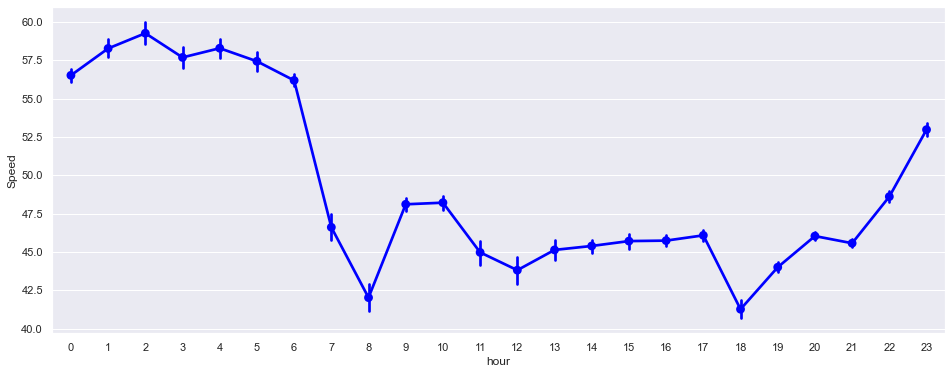

In [41]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,x=df.hour,y=df.Speed,color="blue")

**Here we can say that between morning 8 to 9 the Demand is on peak.**

<AxesSubplot:xlabel='day_of_week', ylabel='Speed'>

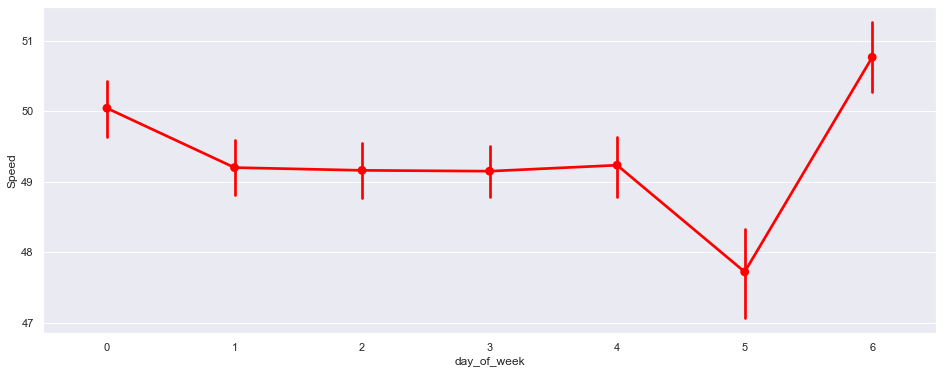

In [43]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,x=df.day_of_week,y=df.Speed,color="red")

**By looking at the above graph we can say that in the July month the demand is on peak and then start to decrease.**

<AxesSubplot:xlabel='hour', ylabel='ToVol'>

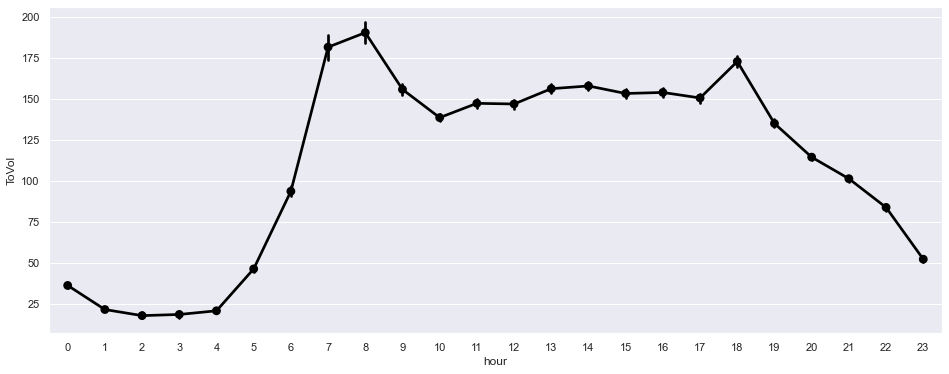

In [46]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,x=df.hour, y=df.ToVol,color="black")

<AxesSubplot:xlabel='hour', ylabel='Occupancy'>

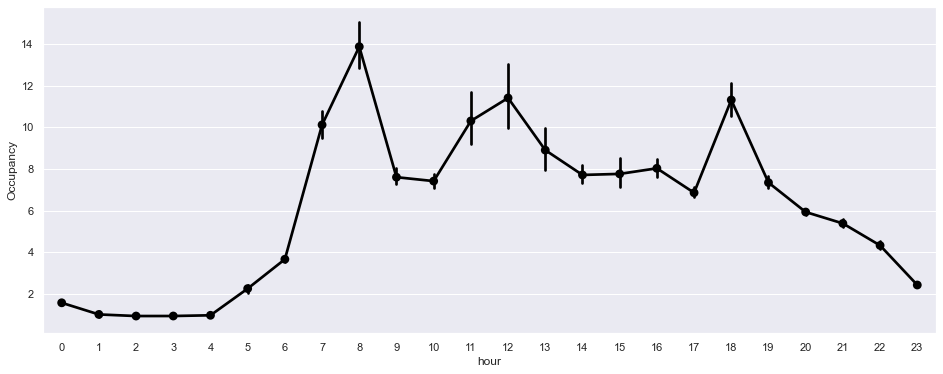

In [50]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,x=df.hour, y=df.Occupancy,color="black")

**Least demand comes from weekend.**

<AxesSubplot:xlabel='day_of_month', ylabel='Speed'>

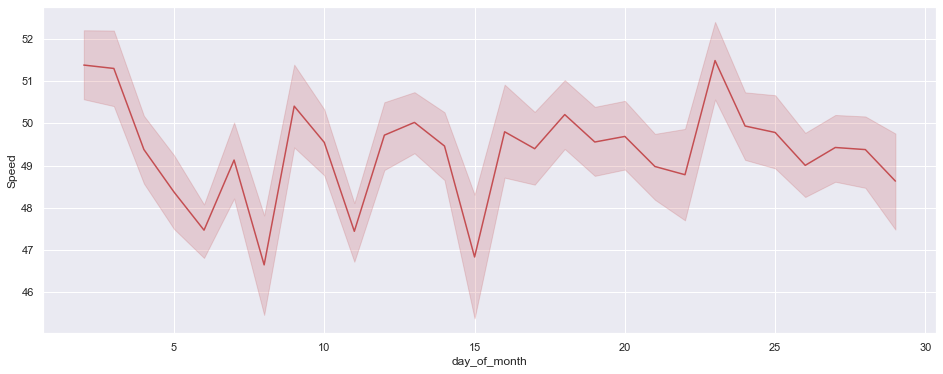

In [51]:
plt.figure(figsize=(16,6))
sns.lineplot(data=df,x=df.day_of_month,y=df.Speed,color="r")

<AxesSubplot:xlabel='ToVol', ylabel='Speed'>

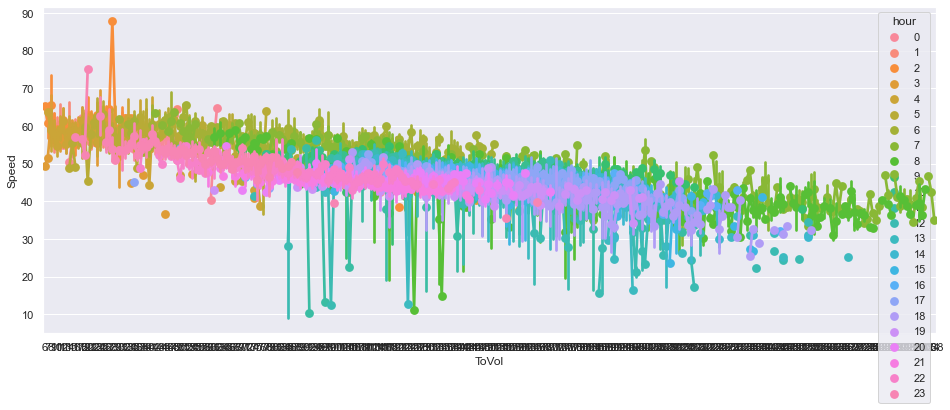

In [53]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,hue=df.hour,y=df.Speed,x=df.ToVol)

In [ ]:
plt.figure(figsize=(16,6))
sns.pointplot(data=df,x=df.hum,y=df.cnt,color="black")
plt.xticks(rotation=90)

<AxesSubplot:xlabel='hour', ylabel='Speed'>

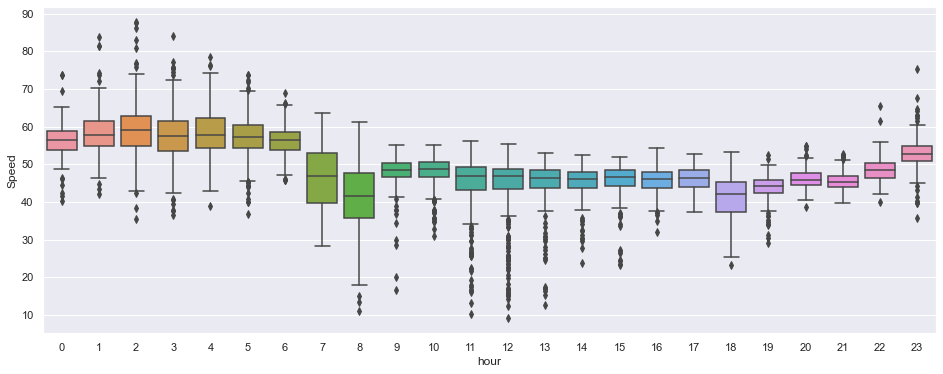

In [54]:
plt.figure(figsize=(16,6))
sns.boxplot(data=df,x=df["hour"],y=df.Speed)

<a id='Preprocessing'></a>
# **Preprocessing**

* Training set = 90% of tha data
* Testing set  = 10% of the data

In [55]:
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,test_size=0.1,random_state=0)

print(train.shape)
print(test.shape)


(7257, 10)
(807, 10)


In [56]:
df.head()

,ToVol,SmVol,MeVol,LaVol,Speed,Occupancy,hour,day_of_month,day_of_week,month
Date,,,,,,,,,,
2017-04-02 00:00:00,43,34,9,0,50.3,1.90,0,2,6,4
2017-04-02 00:05:00,45,32,13,0,58.9,1.84,0,2,6,4
2017-04-02 00:10:00,46,34,12,0,50.6,1.87,0,2,6,4
2017-04-02 00:15:00,45,36,9,0,50.9,1.72,0,2,6,4
2017-04-02 00:20:00,27,13,13,1,62.2,1.12,0,2,6,4


In [57]:
from sklearn.preprocessing import MinMaxScaler
scaler  = MinMaxScaler()

In [58]:
df.columns

Index(['ToVol', 'SmVol', 'MeVol', 'LaVol', 'Speed', 'Occupancy', 'hour',
       'day_of_month', 'day_of_week', 'month'],
      dtype='object')

In [60]:
num_colu = ['ToVol', 'Occupancy']
trans_1 = scaler.fit(train[num_colu].to_numpy())
train.loc[:,num_colu] = trans_1.transform(train[num_colu].to_numpy())
test.loc[:,num_colu] = trans_1.transform(test[num_colu].to_numpy())

In [62]:
spd_scaler = MinMaxScaler()
trans_2 = spd_scaler.fit(train[["Speed"]])
train["Speed"] = trans_2.transform(train[["Speed"]])
test["Speed"] = trans_2.transform(test[["Speed"]])

In [63]:
from tqdm import tqdm_notebook as tqdm

#from tqdm.notebook import tqdm

tqdm().pandas()
def prepare_data(X,y,time_steps=1):
    Xs = []
    Ys = []
    for i in tqdm(range(len(X) - time_steps)):
        a = X.iloc[i:(i + time_steps)].to_numpy()
        Xs.append(a)
        Ys.append(y.iloc[i+time_steps])
    return np.array(Xs),np.array(Ys)    

0it [00:00, ?it/s]

In [65]:
windows = 24
X_train , y_train = prepare_data(train,train.Speed,time_steps=windows)
X_test , y_test = prepare_data(test,test.Speed,time_steps=windows)
print("X_train : {}\nX_test : {}\ny_train : {}\ny_test: {}".format(X_train.shape,X_test.shape,y_train.shape,y_test.shape))

  0%|          | 0/7233 [00:00<?, ?it/s]

  0%|          | 0/783 [00:00<?, ?it/s]

X_train : (7233, 24, 10)
X_test : (783, 24, 10)
y_train : (7233,)
y_test: (783,)


<a id='Model Building'></a>
# **Model Building**

In [68]:
### LSTMM model
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout , LSTM , Bidirectional 

In [69]:
X_train.shape

(7233, 24, 10)

In [70]:
print(X_train.shape[0]), print(X_train.shape[1]), print(X_train.shape[2])

7233
24
10


(None, None, None)

In [71]:
model = Sequential()
model.add(Bidirectional(LSTM(128,input_shape=(X_train.shape[1],X_train.shape[2]))))
model.add(Dropout(0.2))
model.add(Dense(1,activation="sigmoid"))
model.compile(optimizer="adam",loss="mse")

In [85]:
with tf.device('/GPU:0'):
    prepared_model = model.fit(X_train,y_train,batch_size=32,epochs=100,validation_data=[X_test,y_test])

Epoch 1/100
227/227 [==============================] - 6s 26ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 2/100
227/227 [==============================] - 6s 28ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 3/100
227/227 [==============================] - 6s 27ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 4/100
227/227 [==============================] - 6s 28ms/step - loss: 0.0102 - val_loss: 0.0094
Epoch 5/100
227/227 [==============================] - 6s 27ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 6/100
227/227 [==============================] - 6s 28ms/step - loss: 0.0101 - val_loss: 0.0093
Epoch 7/100
227/227 [==============================] - 6s 27ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 8/100
227/227 [==============================] - 6s 28ms/step - loss: 0.0101 - val_loss: 0.0095
Epoch 9/100
227/227 [==============================] - 6s 27ms/step - loss: 0.0101 - val_loss: 0.0094
Epoch 10/100
227/227 [==============================] - 6s 27ms/step - loss: 0.010

227/227 [==============================] - 6s 25ms/step - loss: 0.0043 - val_loss: 0.0139
Epoch 81/100
227/227 [==============================] - 5s 24ms/step - loss: 0.0046 - val_loss: 0.0140
Epoch 82/100
227/227 [==============================] - 6s 26ms/step - loss: 0.0044 - val_loss: 0.0140
Epoch 83/100
227/227 [==============================] - 6s 28ms/step - loss: 0.0043 - val_loss: 0.0139
Epoch 84/100
227/227 [==============================] - 6s 25ms/step - loss: 0.0042 - val_loss: 0.0140
Epoch 85/100
227/227 [==============================] - 5s 24ms/step - loss: 0.0040 - val_loss: 0.0141
Epoch 86/100
227/227 [==============================] - 5s 24ms/step - loss: 0.0041 - val_loss: 0.0140
Epoch 87/100
227/227 [==============================] - 6s 25ms/step - loss: 0.0039 - val_loss: 0.0143
Epoch 88/100
227/227 [==============================] - 5s 23ms/step - loss: 0.0040 - val_loss: 0.0140
Epoch 89/100
227/227 [==============================] - 6s 25ms/step - loss: 0.0042 - 

Text(0, 0.5, 'mse score')

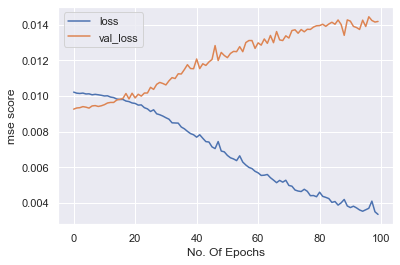

In [86]:
plt.plot(prepared_model.history["loss"],label="loss")
plt.plot(prepared_model.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")
plt.ylabel("mse score")

<a id='Demand Predictions'></a>
# **Demand Predictions**

In [87]:
pred = model.predict(X_test)

25/25 [==============================] - 0s 9ms/step


In [88]:
y_test_inv = spd_scaler.inverse_transform(y_test.reshape(-1,1))
pred_inv = spd_scaler.inverse_transform(pred)

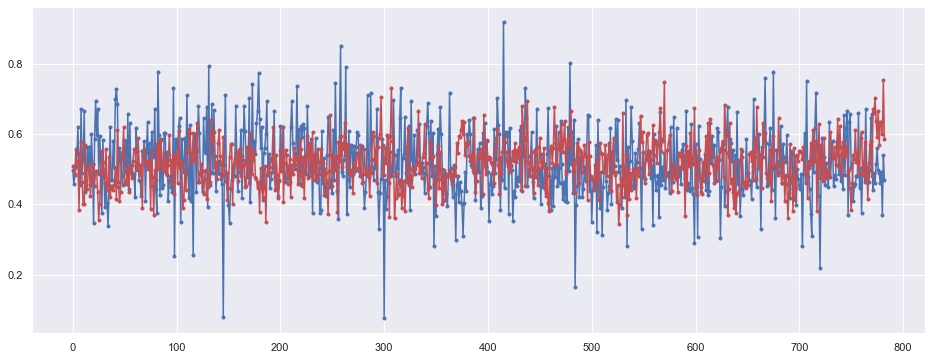

In [89]:
plt.figure(figsize=(16,6))
plt.plot(y_test_inv.flatten(),marker=".",label="actual")
plt.plot(pred_inv.flatten(),marker=".",label="prediction",color="r")

**Note that our model is predicting only one point in the future. That being said, it is doing very well. Although our model can’t really capture the extreme values it does a good job of predicting (understanding) the general pattern.**

In [90]:
y_test_actual = spd_scaler.inverse_transform(y_test.reshape(-1,1))
y_test_pred = spd_scaler.inverse_transform(pred)

In [91]:
arr_1 = np.array(y_test_actual)
arr_2 = np.array(y_test_pred)

In [92]:
actual = pd.DataFrame(data=arr_1.flatten(),columns=["actual"])
predicted = pd.DataFrame(data=arr_2.flatten(),columns = ["predicted"])

In [93]:
final = pd.concat([actual,predicted],axis=1)
final.head()

,actual,predicted
0,0.496823,0.507836
1,0.457433,0.508419
2,0.482846,0.485548
3,0.506989,0.557659
4,0.542567,0.517221


<a id='Evaluation'></a>
# **Evaluation**

In [94]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(final.actual,final.predicted)
rmse = np.sqrt(mean_squared_error(final.actual,final.predicted)) 
r2 = r2_score(final.actual,final.predicted) 
print("mse is : {}\nrmse is : {}\nr2 is : {} ".format(mse,rmse,r2))

mse is : 0.014186242949233745
rmse is : 0.11910601558793639
r2 is : -0.5401260087491069 


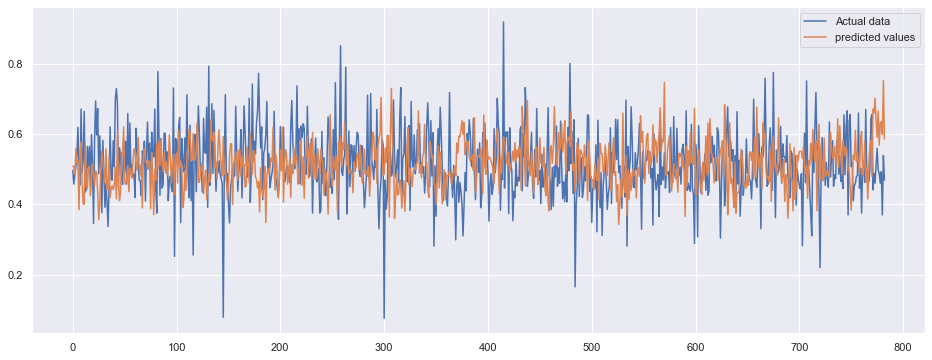

In [95]:
plt.figure(figsize=(16,6))
plt.plot(final.actual,label="Actual data")
plt.plot(final.predicted,label="predicted values")
plt.legend(loc="best")

# Conclusion : 
**AS you can see that I have used Bidirectional LSTM to train our model and Our model is working quite well.Our model is capable to capture the trend and not capturing the Extreme values which is a really good thing. SO, we can say that the overall perfomance is good.**

# If you like this notebook Please Do give an Upvote.


[](http://)